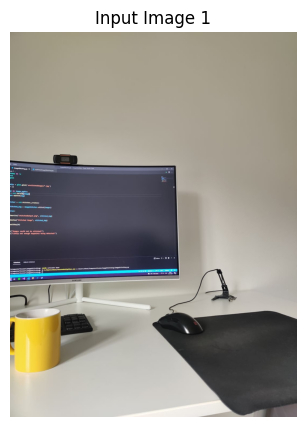

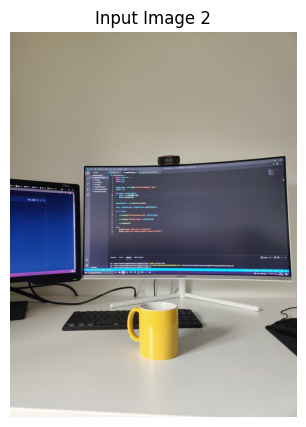

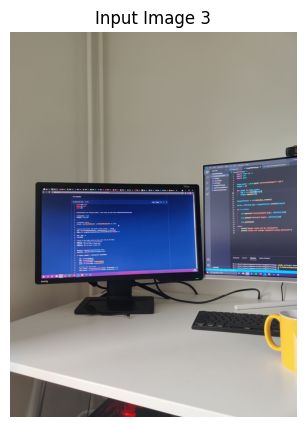

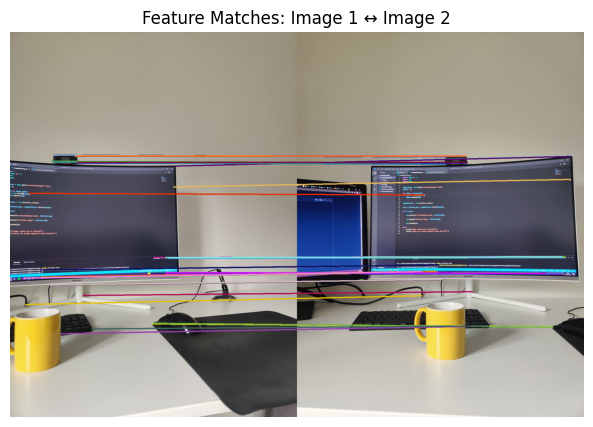

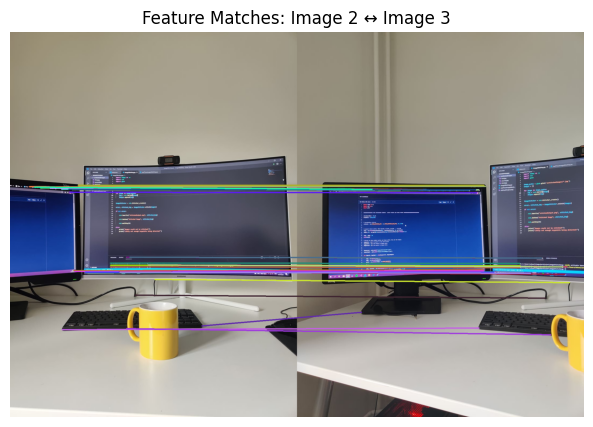

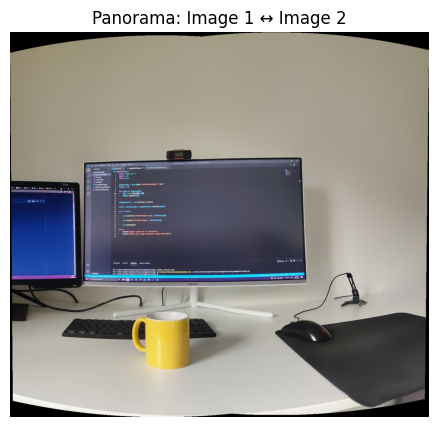

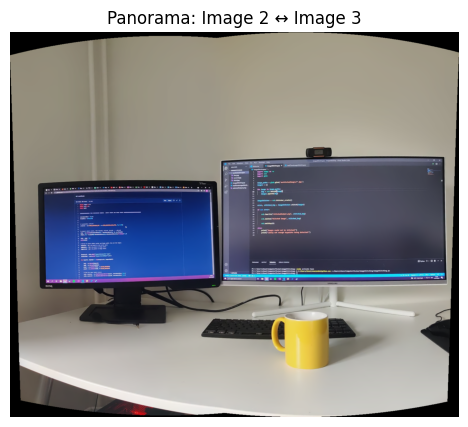

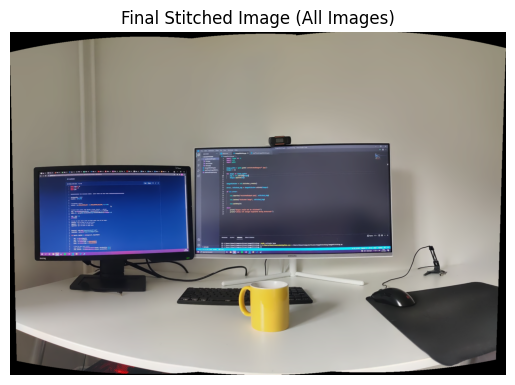

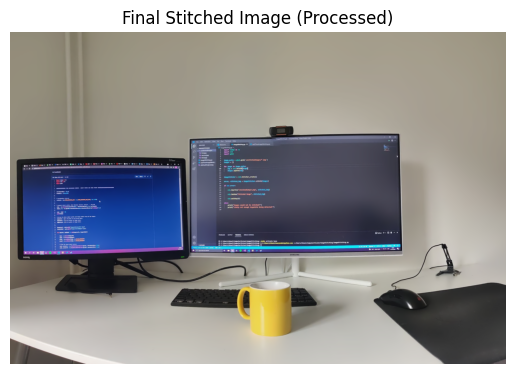

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random

# Fetch all images in the 'images' folder
image_paths = sorted(glob.glob('./images/*.jpg'))  # Sort to maintain order

# Ensure there are at least 3 images
if len(image_paths) < 3:
    print("Not enough images! At least 3 images are required.")
else:
    # Load the images
    img1 = cv2.imread(image_paths[0])
    img2 = cv2.imread(image_paths[1])
    img3 = cv2.imread(image_paths[2])

    # Step 1: Display Input Images
    def show_image(img, title):
        """ Displays an image using Matplotlib. """
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(title)
        plt.show()

    show_image(img1, "Input Image 1")
    show_image(img2, "Input Image 2")
    show_image(img3, "Input Image 3")

    # Step 2: Show Feature Matches with Thicker Lines and Unique Colors
    def draw_feature_matches(imgA, imgB, title):
        """ Detects keypoints, computes descriptors, and draws thicker matches while keeping unique colors. """
        orb = cv2.ORB_create()  # ORB Feature Detector

        # Find keypoints and descriptors
        kpA, desA = orb.detectAndCompute(imgA, None)
        kpB, desB = orb.detectAndCompute(imgB, None)

        # Match descriptors using BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(desA, desB)
        matches = sorted(matches, key=lambda x: x.distance)[:50]  # Keep best 50 matches

        # Create a blank image to draw matches
        hA, wA = imgA.shape[:2]
        hB, wB = imgB.shape[:2]
        match_img = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")

        # Place both images side by side
        match_img[:hA, :wA] = imgA
        match_img[:hB, wA:] = imgB

        # Draw thicker lines while keeping different colors
        for match in matches:
            ptA = tuple(map(int, kpA[match.queryIdx].pt))
            ptB = tuple(map(int, kpB[match.trainIdx].pt))
            ptB = (ptB[0] + wA, ptB[1])  # Adjust for second image

            color = [random.randint(0, 255) for _ in range(3)]  # Random color per match
            cv2.line(match_img, ptA, ptB, color, thickness=3)  # Thicker line

        # Display feature map
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(title)
        plt.show()

    draw_feature_matches(img1, img2, "Feature Matches: Image 1 ↔ Image 2")
    draw_feature_matches(img2, img3, "Feature Matches: Image 2 ↔ Image 3")

    # Step 3: Show Stitched Panoramas
    def stitch_and_show(imgA, imgB, title):
        """ Stitches two images and displays the result. """
        stitcher = cv2.Stitcher_create()
        status, result = stitcher.stitch([imgA, imgB])

        if status == cv2.Stitcher_OK:
            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title(title)
            plt.show()
            return result
        else:
            print(f"Stitching failed for {title}!")
            return None

    pano1 = stitch_and_show(img1, img2, "Panorama: Image 1 ↔ Image 2")
    pano2 = stitch_and_show(img2, img3, "Panorama: Image 2 ↔ Image 3")

    # Step 4: Final stitching of all images
    imageStitcher = cv2.Stitcher_create()
    error, stitched_img = imageStitcher.stitch([img1, img2, img3])

    if error == cv2.Stitcher_OK:
        cv2.imwrite("./stitchedOutput.png", stitched_img)

        plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Final Stitched Image (All Images)")
        plt.show()

        # Step 5: Process the final stitched image
        stitched_img = cv2.copyMakeBorder(stitched_img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, (0, 0, 0))

        # Convert to grayscale and apply threshold
        gray = cv2.cvtColor(stitched_img, cv2.COLOR_BGR2GRAY)
        thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

        # Find contours
        contours, _ = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        areaOI = max(contours, key=cv2.contourArea)

        # Create mask
        mask = np.zeros(thresh_img.shape, dtype="uint8")
        x, y, w, h = cv2.boundingRect(areaOI)
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

        minRectangle = mask.copy()
        sub = mask.copy()

        while cv2.countNonZero(sub) > 0:
            minRectangle = cv2.erode(minRectangle, None)
            sub = cv2.subtract(minRectangle, thresh_img)

        # Find the bounding box of the cleaned mask
        contours, _ = cv2.findContours(minRectangle.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        areaOI = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(areaOI)

        # Crop the final stitched image
        stitched_img = stitched_img[y:y + h, x:x + w]

        # Save and display final processed image
        cv2.imwrite("./stitchedOutputProcessed.png", stitched_img)

        plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Final Stitched Image (Processed)")
        plt.show()

    else:
        print("Final stitching failed! Likely not enough keypoints being detected.")
